In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import torch
from torch import nn
import numpy as np
from stacked_mnist import StackedMNISTData, DataMode

In [63]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            # nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            # nn.BatchNorm2d(32),
            nn.ReLU(True),
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim),
        )

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [64]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [65]:
d = 8
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [67]:
loss_fn = torch.nn.BCELoss()
lr= 0.001
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [68]:
### Training function
def train_epoch(encoder, decoder, loss_fn, optimizer, x):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []

    # Encode data
    encoded_data = encoder(x)
    # Decode data
    decoded_data = decoder(encoded_data)
    # Evaluate loss
    loss = loss_fn(decoded_data, x)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print batch loss
    print('\t partial train loss (single batch): %f' % (loss.data))
    train_loss.append(loss.detach().numpy())

    return train_loss

In [69]:
### Testing function
def test_epoch(encoder, decoder, loss_fn, x):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        # Encode data
        encoded_data = encoder(x)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Append the network output and the original image to the lists
        conc_out.append(decoded_data)
        conc_label.append(x)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [51]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)

In [70]:
import matplotlib.pyplot as plt
import random 
num_epochs = 1000
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   img_train, labels_train = generator.get_random_batch(training=True)
   img_test, labels_test = generator.get_random_batch(training=False)
   #print(img_train[0])
   #img = img_train[0]
   #plt.imshow(np.array(img).reshape((28, 28)))


   img_train = torch.tensor(img_train)
   img_train = img_train.type(torch.FloatTensor)
   img_test = torch.tensor(img_test)
   img_test = img_test.type(torch.FloatTensor)
   train_loss = train_epoch(encoder,decoder,loss_fn,optim, img_train)
   val_loss = test_epoch(encoder,decoder,loss_fn, img_test)
   print(f"Epoch {epoch+1}/{num_epochs} train loss: {train_loss}, val loss: {val_loss}")
   #print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)

	 partial train loss (single batch): 0.796594
Epoch 1/1000 train loss: [array(0.7965939, dtype=float32)], val loss: 0.72342449426651
	 partial train loss (single batch): 0.780184
Epoch 2/1000 train loss: [array(0.7801836, dtype=float32)], val loss: 0.7235666513442993
	 partial train loss (single batch): 0.765440
Epoch 3/1000 train loss: [array(0.76544017, dtype=float32)], val loss: 0.7237394452095032
	 partial train loss (single batch): 0.753330
Epoch 4/1000 train loss: [array(0.75333, dtype=float32)], val loss: 0.7235433459281921
	 partial train loss (single batch): 0.744719
Epoch 5/1000 train loss: [array(0.7447194, dtype=float32)], val loss: 0.723918616771698
	 partial train loss (single batch): 0.736432
Epoch 6/1000 train loss: [array(0.73643154, dtype=float32)], val loss: 0.7243598103523254
	 partial train loss (single batch): 0.729565
Epoch 7/1000 train loss: [array(0.7295654, dtype=float32)], val loss: 0.7239956259727478
	 partial train loss (single batch): 0.723727
Epoch 8/1000

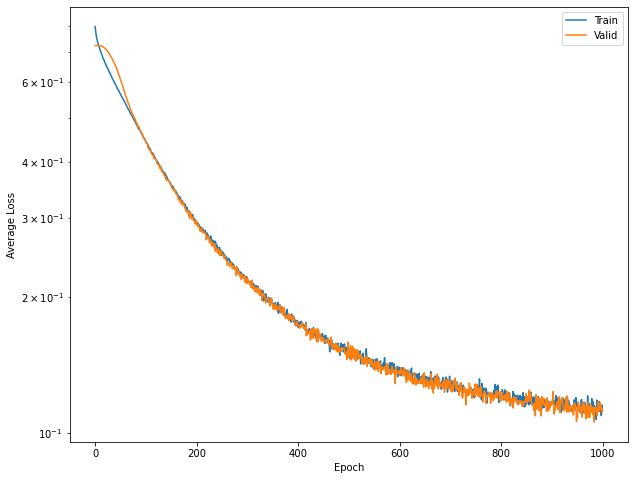

In [71]:
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

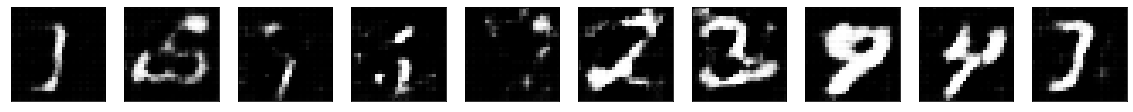

In [110]:
z = np.random.randn(100, 8)
z = torch.Tensor(z)
with torch.no_grad():
    x_hat = decoder(z)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(np.array(x_hat[i]).reshape((28, 28)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [1]:
from verification_net import VerificationNet
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
img, labels = generator.get_random_batch(training=False, batch_size=1000)
x = torch.Tensor(img)
x = x.type(torch.FloatTensor)

with torch.no_grad():
    auto_encoded_imgs = np.array(decoder(encoder(x)))
auto_encoded_imgs = auto_encoded_imgs.swapaxes(1, 2)
auto_encoded_imgs = auto_encoded_imgs.swapaxes(2, 3)
img = img.swapaxes(1, 2)
img = img.swapaxes(2, 3)

_, acc_ae = net.check_predictability(data=auto_encoded_imgs, correct_labels=labels)
print(f"Accuracy AE: {100 * acc_ae:.2f}%")
_, acc_orig = net.check_predictability(data=img, correct_labels=labels)
print(f"Accuracy Original: {100 * acc_orig:.2f}%")



2022-02-26 13:16:38.226882: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


NameError: name 'generator' is not defined